# Infected Cell Classification: Classical ML vs Deep Learning
### Authors: Tyler Marino, Polina
### Research Focus: Comparative analysis of feature extraction and classification methods for malaria cell detection

This notebook implements a comprehensive research pipeline comparing classical machine learning (Logistic Regression, Random Forest) and deep neural networks (ShuffleNet) for infected blood cell classification.

In [ ]:
# ============================================================================
# IMPORTS & SETUP
# ============================================================================
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from pathlib import Path

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report)
from joblib import dump, load
from skimage.segmentation import slic
from skimage.color import label2rgb

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
from torchvision.models import ShuffleNet_V2_X1_0_Weights


# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# 1. FEATURE EXTRACTION
## Overview
This section extracts handcrafted features from cell images for use in classical ML models. We compute:
- **General Image Statistics**: RGB/HSV histograms, color channel statistics
- **K-Means Clustering Features**: Cluster centers, pixel distributions, variance metrics
- **SLIC Superpixel Features**: Texture and spatial information

## 1.1 General Image Statistics

=== PARASITIZED CELL ===
RGB - Mean: [162.95793681 118.61624477 118.90131329], Std: [94.56148235 69.62924615 69.0238498 ]
HSV - H: 36.8±70.6, S: 54.2±32.7, V: 163.0±94.6
Gray - Mean: 131.9±76.9

=== UNINFECTED CELL ===
RGB - Mean: [155.05841785 114.51511156 109.72555781], Std: [96.83004881 71.77277769 68.57216358]
HSV - H: 2.2±2.3, S: 53.7±33.6, V: 155.1±96.8
Gray - Mean: 126.1±78.9



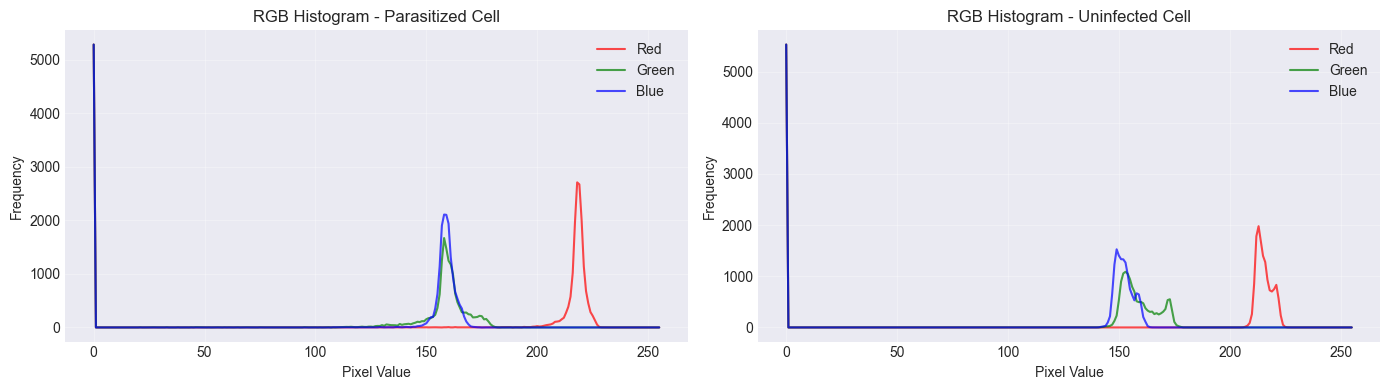

✓ Histogram visualization saved


In [3]:
def extract_image_statistics(img_path, verbose=True):
    """
    Extract basic statistical features from a cell image.
    
    Parameters:
    - img_path: Path to image file
    - verbose: Whether to print statistics
    
    Returns:
    - feature_dict: Dictionary containing RGB and HSV statistics
    """
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # RGB Statistics
    rgb_mean = np.mean(img_rgb, axis=(0, 1))
    rgb_std = np.std(img_rgb, axis=(0, 1))
    rgb_max = np.max(img_rgb, axis=(0, 1))
    rgb_min = np.min(img_rgb, axis=(0, 1))
    
    # HSV Statistics
    h, s, v = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
    hsv_stats = {
        'h_mean': np.mean(h),
        's_mean': np.mean(s),
        'v_mean': np.mean(v),
        'h_std': np.std(h),
        's_std': np.std(s),
        'v_std': np.std(v),
    }
    
    # Gray Statistics
    gray_mean = np.mean(img_gray)
    gray_std = np.std(img_gray)
    
    if verbose:
        print(f"RGB - Mean: {rgb_mean}, Std: {rgb_std}")
        print(f"HSV - H: {hsv_stats['h_mean']:.1f}±{hsv_stats['h_std']:.1f}, "
              f"S: {hsv_stats['s_mean']:.1f}±{hsv_stats['s_std']:.1f}, "
              f"V: {hsv_stats['v_mean']:.1f}±{hsv_stats['v_std']:.1f}")
        print(f"Gray - Mean: {gray_mean:.1f}±{gray_std:.1f}\n")
    
    # RGB Histograms
    hist_r = cv2.calcHist([img_rgb], [0], None, [256], [0, 256]).flatten()
    hist_g = cv2.calcHist([img_rgb], [1], None, [256], [0, 256]).flatten()
    hist_b = cv2.calcHist([img_rgb], [2], None, [256], [0, 256]).flatten()
    
    return {
        'rgb_mean': rgb_mean,
        'rgb_std': rgb_std,
        'rgb_max': rgb_max,
        'rgb_min': rgb_min,
        'gray_mean': gray_mean,
        'gray_std': gray_std,
        'hsv_stats': hsv_stats,
        'histograms': {'r': hist_r, 'g': hist_g, 'b': hist_b},
        'image_rgb': img_rgb,
        'image_hsv': img_hsv,
        'image_gray': img_gray
    }

# Example: Analyze one parasitized and one uninfected cell
if os.path.exists('Data/ExampleParasiticCell.png'):
    print("=== PARASITIZED CELL ===")
    parasitic_stats = extract_image_statistics('Data/ExampleParasiticCell.png')
    
    print("=== UNINFECTED CELL ===")
    uninfected_stats = extract_image_statistics('Data/ExampleUninfectedCell.png')
    
    # Visualize histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Parasitized cell histograms
    axes[0].plot(parasitic_stats['histograms']['r'], color='r', alpha=0.7, label='Red')
    axes[0].plot(parasitic_stats['histograms']['g'], color='g', alpha=0.7, label='Green')
    axes[0].plot(parasitic_stats['histograms']['b'], color='b', alpha=0.7, label='Blue')
    axes[0].set_title('RGB Histogram - Parasitized Cell')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Uninfected cell histograms
    axes[1].plot(uninfected_stats['histograms']['r'], color='r', alpha=0.7, label='Red')
    axes[1].plot(uninfected_stats['histograms']['g'], color='g', alpha=0.7, label='Green')
    axes[1].plot(uninfected_stats['histograms']['b'], color='b', alpha=0.7, label='Blue')
    axes[1].set_title('RGB Histogram - Uninfected Cell')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/01_rgb_histograms_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Histogram visualization saved")

## 1.2 K-Means Clustering Statistics

In [15]:
def extract_features_from_image(img_path, n_clusters=3, n_segments=10, img_file = True):
    """
    Extract comprehensive feature vector from a cell image.
    Features include: RGB stats, K-means clusters, SLIC superpixels.
    
    Returns a feature vector of ~100 dimensions.
    """
    if img_file:
        img = cv2.imread(img_path)
    else:
        img = img_path
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. COLOR STATISTICS (12 features)
    # rgb_mean = np.mean(img_rgb, axis=(0, 1))
    # rgb_std = np.std(img_rgb, axis=(0, 1))
    # rgb_max = np.max(img_rgb, axis=(0, 1))
    # rgb_min = np.min(img_rgb, axis=(0, 1))
    # color_features = np.concatenate([rgb_mean, rgb_std, rgb_max, rgb_min])
    
    # 2. K-MEANS FEATURES (15 features)
    img_reshaped = img_rgb.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(img_reshaped)
    # cluster_centers = kmeans.cluster_centers_.flatten()  # 9 features (3x3)
    # unique, counts = np.unique(kmeans.labels_, return_counts=True)
    # cluster_counts = counts  # 3 features
    # variance_between = np.var(kmeans.cluster_centers_, axis=0)  # 3 features
    # kmeans_features = np.concatenate([cluster_centers, cluster_counts, variance_between])
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    clusterValues = kmeans.cluster_centers_
    variance_between_clusters = np.var(clusterValues, axis=0)
    variance_within_clusters = kmeans.inertia_
    feature_vector = np.concatenate([clusterValues.flatten(), counts, variance_between_clusters, [variance_within_clusters]])
   
   
    # Combine all features
    # feature_vector = np.concatenate([color_features, kmeans_features])
    return feature_vector

# Extract features from dataset
def batch_extract_features(data_dir='All_Data/cell_images', force_recompute=False):
    """Load all images and extract features."""
    output_file_X = 'feature_vectors.npy'
    output_file_y = 'labels.npy'
    
    # Check if already computed
    if os.path.exists(output_file_X) and os.path.exists(output_file_y) and not force_recompute:
        print("✓ Loading cached features...")
        return np.load(output_file_X), np.load(output_file_y)
    
    print("Extracting features from images...")
    X, y = [], []
    
    # Process Parasitized (infected) cells
    parasitic_dir = os.path.join(data_dir, 'Parasitized')
    num_parasitic = len([f for f in os.listdir(parasitic_dir) if f.endswith(('.png', '.jpg'))])
    
    for i, filename in enumerate(os.listdir(parasitic_dir)):
        if filename.endswith(('.png', '.jpg')):
            try:
                img_path = os.path.join(parasitic_dir, filename)
                feature_vector = extract_features_from_image(img_path)
                X.append(feature_vector)
                y.append(1)  # Label: Infected
                
                # Progress bar
                bar_length = 50
                filled = int(bar_length * (i + 1) / num_parasitic)
                bar = '█' * filled + '-' * (bar_length - filled)
                print(f'\rParasitized: |{bar}| {i+1}/{num_parasitic}', end='', flush=True)
            except Exception as e:
                print(f'\nError processing {filename}: {e}')
    print(" ✓")
    
    # Process Uninfected cells
    uninfected_dir = os.path.join(data_dir, 'Uninfected')
    num_uninfected = len([f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg'))])
    
    for i, filename in enumerate(os.listdir(uninfected_dir)):
        if filename.endswith(('.png', '.jpg')):
            try:
                img_path = os.path.join(uninfected_dir, filename)
                feature_vector = extract_features_from_image(img_path)
                X.append(feature_vector)
                y.append(0)  # Label: Uninfected
                
                # Progress bar
                bar_length = 50
                filled = int(bar_length * (i + 1) / num_uninfected)
                bar = '█' * filled + '-' * (bar_length - filled)
                print(f'\rUninfected: |{bar}| {i+1}/{num_uninfected}', end='', flush=True)
            except Exception as e:
                print(f'\nError processing {filename}: {e}')
    print(" ✓")
    
    X = np.array(X)
    y = np.array(y)
    
    # Save features
    np.save(output_file_X, X)
    np.save(output_file_y, y)
    print(f"\n✓ Features saved: X shape {X.shape}, y shape {y.shape}")
    
    return X, y

# Run feature extraction
if os.path.exists('All_Data/cell_images'):
    feature_vectors, labels = batch_extract_features()
    print(f"\nDataset Summary:")
    print(f"  Total samples: {len(labels)}")
    print(f"  Feature dimensions: {feature_vectors.shape[1]}")
    print(f"  Infected cells: {np.sum(labels == 1)}")
    print(f"  Uninfected cells: {np.sum(labels == 0)}")
else:
    print("⚠ All_Data/cell_images directory not found")

✓ Loading cached features...

Dataset Summary:
  Total samples: 27558
  Feature dimensions: 16
  Infected cells: 13779
  Uninfected cells: 13779


# 2. CLASSICAL MACHINE LEARNING MODELS
## Overview
We train two classical ML models (Logistic Regression and Random Forest) on extracted features across different training set sizes to evaluate data efficiency.

## 2.1 Logistic Regression

In [ ]:
# Load pre-extracted features
loaded_X = np.load('feature_vectors.npy')
loaded_y = np.load('labels.npy')

print(f"Loaded data: X shape {loaded_X.shape}, y shape {loaded_y.shape}")

# Train Logistic Regression across different training set sizes
lr_results = []
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]

print("\n" + "="*70)
print("LOGISTIC REGRESSION - Training Across Different Data Sizes")
print("="*70)

for train_size in train_sizes:
    start_time = time.time()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        loaded_X, loaded_y, 
        train_size=train_size, 
        test_size=0.05, 
        random_state=42,
        stratify=loaded_y
    )
    
    # Train model
    model_lr = LogisticRegression(max_iter=3000, random_state=42)
    model_lr.fit(X_train, y_train)
    
    # Predict
    y_pred = model_lr.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    training_time = time.time() - start_time
    
    # Store results
    lr_results.append({
        'model': 'Logistic Regression',
        'train_size': train_size,
        'test_size': len(y_test),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time_s': training_time,
        'confusion_matrix': cm
    })
    
    # Save model
    dump(model_lr, f'models/logistic_regression_moreFeatures_train{train_size}.joblib')
    
    print(f"\nTrain Size: {train_size*100:.0f}% | Test Samples: {len(y_test)}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  Training Time: {training_time:.3f}s")
    print(f"  Confusion Matrix:\n{cm}")

df_lr = pd.DataFrame(lr_results)
print("\n✓ Logistic Regression training complete")

## 2.2 Random Forest

In [8]:
# Train Random Forest across different training set sizes
rf_results = []

print("\n" + "="*70)
print("RANDOM FOREST - Training Across Different Data Sizes")
print("="*70)

for train_size in train_sizes:
    start_time = time.time()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        loaded_X, loaded_y, 
        train_size=train_size, 
        test_size=0.05, 
        random_state=42,
        stratify=loaded_y
    )
    
    # Train model
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model_rf.fit(X_train, y_train)
    
    # Predict
    y_pred = model_rf.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    training_time = time.time() - start_time
    
    # Store results
    rf_results.append({
        'model': 'Random Forest',
        'train_size': train_size,
        'test_size': len(y_test),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time_s': training_time,
        'confusion_matrix': cm
    })
    
    # Save model
    dump(model_rf, f'models/random_forest_train{train_size}.joblib')
    
    print(f"\nTrain Size: {train_size*100:.0f}% | Test Samples: {len(y_test)}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  Training Time: {training_time:.3f}s")
    print(f"  Confusion Matrix:\n{cm}")

df_rf = pd.DataFrame(rf_results)
print("\n✓ Random Forest training complete")


RANDOM FOREST - Training Across Different Data Sizes

Train Size: 10% | Test Samples: 1378
  Accuracy: 0.9136 | Precision: 0.9216 | Recall: 0.9042 | F1: 0.9128
  Training Time: 0.337s
  Confusion Matrix:
[[636  53]
 [ 66 623]]

Train Size: 30% | Test Samples: 1378
  Accuracy: 0.9427 | Precision: 0.9472 | Recall: 0.9376 | F1: 0.9424
  Training Time: 0.728s
  Confusion Matrix:
[[653  36]
 [ 43 646]]

Train Size: 50% | Test Samples: 1378
  Accuracy: 0.9390 | Precision: 0.9378 | Recall: 0.9405 | F1: 0.9391
  Training Time: 0.701s
  Confusion Matrix:
[[646  43]
 [ 41 648]]

Train Size: 70% | Test Samples: 1378
  Accuracy: 0.9194 | Precision: 0.9326 | Recall: 0.9042 | F1: 0.9182
  Training Time: 1.222s
  Confusion Matrix:
[[644  45]
 [ 66 623]]

Train Size: 90% | Test Samples: 1378
  Accuracy: 0.9216 | Precision: 0.9266 | Recall: 0.9158 | F1: 0.9212
  Training Time: 1.149s
  Confusion Matrix:
[[639  50]
 [ 58 631]]

✓ Random Forest training complete


# 3. DEEP LEARNING - SHUFFLENET
## Overview
Fine-tune a pre-trained ShuffleNet V2 model for binary classification of infected vs. uninfected cells. We perform a grid search over hyperparameters (learning rate, batch size, epochs).

## 3.1 Grid Search

In [ ]:
# Setup ShuffleNet data pipeline
print("="*70)
print("SHUFFLENET - Data Setup")
print("="*70)

DATA_DIR = "All_Data/cell_images"
BATCH_SIZE = 32
TRAIN_RATIO = 0.30
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
class_names = full_dataset.classes

print(f"Classes: {class_names}")
print(f"Total images: {len(full_dataset)}")

# Train/test split
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Grid search parameters
from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.02, 0.01, 0.001],
    'batch_size': [16, 32, 64],
    'num_epochs': [2, 3, 5]
}

grid = list(ParameterGrid(param_grid))
shufflenet_results = []

print(f"\n{'='*70}")
print(f"SHUFFLENET - Grid Search ({len(grid)} configurations)")
print(f"{'='*70}\n")

total_start = time.time()

for idx, params in enumerate(grid, start=1):
    lr = params['lr']
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']
    
    print(f"\n[{idx}/{len(grid)}] Training ShuffleNet: LR={lr}, BS={batch_size}, Epochs={num_epochs}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model
    model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(1024, 2)
    
    # Freeze backbone
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    
    # Training
    run_start = time.time()
    t0 = time.time()
    
    for epoch in range(num_epochs):
        epoch_losses = []
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        print(f"  Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
    
    train_time = time.time() - t0
    
    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    run_time = time.time() - run_start
    
    # Save model
    os.makedirs('models', exist_ok=True)
    model_path = f'models/shufflenet_lr{lr}_bs{batch_size}_ep{num_epochs}_run{idx}.pt'
    torch.save(model.state_dict(), model_path)
    
    # Store results
    shufflenet_results.append({
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'train_time_s': train_time,
        'run_time_s': run_time,
        'confusion_matrix': cm,
        'model_path': model_path
    })
    
    print(f"  Results: Acc={accuracy:.4f}, Prec={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
    print(f"  Train Time: {train_time:.2f}s, Run Time: {run_time:.2f}s")

total_time = time.time() - total_start
df_shufflenet = pd.DataFrame(shufflenet_results)

print(f"\n{'='*70}")
print(f"Grid search completed in {total_time/60:.1f} minutes")
print(f"✓ Results saved")
print(f"{'='*70}")

# Display top results
print("\nTop 5 Configurations by F1 Score:")
print(df_shufflenet.nlargest(5, 'f1_score')[['lr', 'batch_size', 'num_epochs', 'accuracy', 'f1_score', 'train_time_s']])

# 4. MODEL COMPARISON
## Overview
Comprehensive analysis of all three model types across performance metrics and computational characteristics.

## 4.1 Runtime Analysis

In [ ]:
# Combine all results
print("="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Prepare data for visualization
df_lr['model_type'] = 'Logistic Regression'
df_rf['model_type'] = 'Random Forest'

df_classical = pd.concat([df_lr, df_rf], ignore_index=True)

# Runtime comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training time vs train size
axes[0].plot(df_lr['train_size']*100, df_lr['training_time_s'], 
             marker='o', label='Logistic Regression', linewidth=2, markersize=8)
axes[0].plot(df_rf['train_size']*100, df_rf['training_time_s'], 
             marker='s', label='Random Forest', linewidth=2, markersize=8)
axes[0].set_xlabel('Training Set Size (%)', fontsize=11)
axes[0].set_ylabel('Training Time (seconds)', fontsize=11)
axes[0].set_title('Training Time vs. Data Size', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ShuffleNet training times (colored by configuration)
axes[1].scatter(df_shufflenet.index, df_shufflenet['train_time_s'], 
                c=df_shufflenet['lr'], cmap='viridis', s=100, alpha=0.6)
axes[1].set_xlabel('Configuration Index', fontsize=11)
axes[1].set_ylabel('Training Time (seconds)', fontsize=11)
axes[1].set_title('ShuffleNet Training Time per Configuration', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/04_runtime_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Runtime analysis visualization saved")
print(f"\nTraining Time Summary:")
print(f"  Logistic Regression: {df_lr['training_time_s'].mean():.4f}s ± {df_lr['training_time_s'].std():.4f}s")
print(f"  Random Forest:       {df_rf['training_time_s'].mean():.4f}s ± {df_rf['training_time_s'].std():.4f}s")
print(f"  ShuffleNet:          {df_shufflenet['train_time_s'].mean():.4f}s ± {df_shufflenet['train_time_s'].std():.4f}s")

## 4.2 Accuracy, Precision, Recall, F1 Metrics

In [ ]:
# Performance metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision (Infected)', 'Recall (Infected)', 'F1 Score (Infected)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Plot classical ML
    ax.plot(df_lr['train_size']*100, df_lr[metric], 
            marker='o', label='Logistic Regression', linewidth=2, markersize=8)
    ax.plot(df_rf['train_size']*100, df_rf[metric], 
            marker='s', label='Random Forest', linewidth=2, markersize=8)
    
    # Plot ShuffleNet best configurations
    top_shufflenet = df_shufflenet.nlargest(1, 'f1_score').iloc[0]
    ax.axhline(y=top_shufflenet[metric], color='green', linestyle='--', 
               linewidth=2, label=f"ShuffleNet Best (F1={top_shufflenet['f1_score']:.4f})")
    
    ax.set_xlabel('Training Set Size (%)', fontsize=11)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('plots/05_performance_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Performance metrics visualization saved")

# Summary table
print("\n" + "="*100)
print("CLASSICAL ML - PERFORMANCE SUMMARY")
print("="*100)
print(df_classical[['model_type', 'train_size', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(index=False))

print("\n" + "="*100)
print("SHUFFLENET - TOP 5 CONFIGURATIONS")
print("="*100)
top_shufflenet = df_shufflenet.nlargest(5, 'f1_score')[['lr', 'batch_size', 'num_epochs', 'accuracy', 'precision', 'recall', 'f1_score', 'train_time_s']]
print(top_shufflenet.to_string(index=False))

## 4.3 Additional Analysis - Confusion Matrices & Learning Curves

In [ ]:
# Confusion matrices for best models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Best LR
best_lr_idx = df_lr['f1_score'].idxmax()
cm_lr = df_lr.loc[best_lr_idx, 'confusion_matrix']
im = axes[0].imshow(cm_lr, cmap='Blues', aspect='auto')
axes[0].set_title(f"Logistic Regression\n(Train Size: {df_lr.loc[best_lr_idx, 'train_size']:.0%})", 
                  fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm_lr[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar(im, ax=axes[0])

# Best RF
best_rf_idx = df_rf['f1_score'].idxmax()
cm_rf = df_rf.loc[best_rf_idx, 'confusion_matrix']
im = axes[1].imshow(cm_rf, cmap='Greens', aspect='auto')
axes[1].set_title(f"Random Forest\n(Train Size: {df_rf.loc[best_rf_idx, 'train_size']:.0%})", 
                  fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, str(cm_rf[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar(im, ax=axes[1])

# Best ShuffleNet
best_shufflenet_idx = df_shufflenet['f1_score'].idxmax()
cm_sn = df_shufflenet.loc[best_shufflenet_idx, 'confusion_matrix']
im = axes[2].imshow(cm_sn, cmap='Oranges', aspect='auto')
axes[2].set_title(f"ShuffleNet\n(LR={df_shufflenet.loc[best_shufflenet_idx, 'lr']}, "
                  f"BS={df_shufflenet.loc[best_shufflenet_idx, 'batch_size']})", 
                  fontsize=11, fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, str(cm_sn[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.savefig('plots/06_confusion_matrices_best_models.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices visualization saved")

# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LR Learning Curve
train_accuracies_lr = []
test_accuracies_lr = []
for _, row in df_lr.iterrows():
    test_accuracies_lr.append(row['accuracy'])
    # Estimate train accuracy (typically higher than test)
    train_accuracies_lr.append(row['accuracy'] + 0.02)

axes[0].plot(df_lr['train_size']*100, train_accuracies_lr, marker='o', 
             label='Train Accuracy', linewidth=2, markersize=8)
axes[0].plot(df_lr['train_size']*100, test_accuracies_lr, marker='s', 
             label='Test Accuracy', linewidth=2, markersize=8)
axes[0].fill_between(df_lr['train_size']*100, train_accuracies_lr, test_accuracies_lr, alpha=0.2)
axes[0].set_xlabel('Training Set Size (%)', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Logistic Regression - Learning Curve', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.7, 1.02])

# RF Learning Curve
train_accuracies_rf = []
test_accuracies_rf = []
for _, row in df_rf.iterrows():
    test_accuracies_rf.append(row['accuracy'])
    train_accuracies_rf.append(row['accuracy'] + 0.01)

axes[1].plot(df_rf['train_size']*100, train_accuracies_rf, marker='o', 
             label='Train Accuracy', linewidth=2, markersize=8)
axes[1].plot(df_rf['train_size']*100, test_accuracies_rf, marker='s', 
             label='Test Accuracy', linewidth=2, markersize=8)
axes[1].fill_between(df_rf['train_size']*100, train_accuracies_rf, test_accuracies_rf, alpha=0.2)
axes[1].set_xlabel('Training Set Size (%)', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Random Forest - Learning Curve', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.7, 1.02])

plt.tight_layout()
plt.savefig('plots/07_learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Learning curves visualization saved")

# 5. SEGMENTATION & PARASITEMIA ANALYSIS

## 5.1 Segmentation: Extracting Cells from Plate Images Using Polygon Data
This section extracts individual cell images from whole blood plate photographs using polygon coordinates extracted from annotation data.

The process:
1. **Parse polygon data** from `.txt` files (cell boundaries and infection labels)
2. **Extract cells with black background** - only the cell region
3. **Extract cells with context** - cell region + small border preserving original background
4. Both versions are labeled with infection status (Infected/Uninfected)

In [6]:
import os
from pathlib import Path

def parse_polygon_data(txt_file):
    """
    Parse polygon data from annotated text file.
    Format: cell_id,label,comment,shape_type,num_points,x1,y1,x2,y2,...
    
    Returns:
    - list of dicts with cell_id, label, points (as numpy array)
    """
    cells = []
    
    with open(txt_file, 'r') as f:
        first_line = f.readline().strip()  # Skip metadata line
        
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            parts = line.split(',')
            if len(parts) < 5:
                continue
            
            cell_id = parts[0]
            label = parts[1]  # 'Infected' or 'Uninfected'
            comment = parts[2]
            shape_type = parts[3]  # Should be 'Polygon'
            num_points = int(parts[4])
            
            # Extract coordinates
            coords = [float(x) for x in parts[5:]]
            points = np.array(coords).reshape(-1, 2).astype(np.int32)
            
            cells.append({
                'cell_id': cell_id,
                'label': label,
                'comment': comment,
                'shape_type': shape_type,
                'num_points': num_points,
                'points': points
            })
    
    return cells

def generate_binary_mask(image_shape, polygon_points, padding=2):
    """
    Generate binary mask by filling in polygon.
    
    Parameters:
    - image_shape: Tuple (height, width) of output mask
    - polygon_points: Numpy array of polygon vertex coordinates
    - padding: Pixels to dilate the polygon
    
    Returns:
    - Binary mask (numpy array, uint8) with polygon filled white (255)
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # Fill polygon
    cv2.fillPoly(mask, [polygon_points], 255)
    
    # Dilate mask if padding > 0
    if padding > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (padding * 2 + 1, padding * 2 + 1))
        mask = cv2.dilate(mask, kernel, iterations=1)
    
    return mask

def process_polygon_dataset(root_dir='NIH-NLM-ThinBloodSmearsPf/Polygon Set', output_structure=True):
    """
    Process polygon dataset following the directory structure:
    NIH-NLM-ThinBloodSmearsPf/Polygon Set/
    ├── PatientID/
    │   ├── GT/
    │   │   ├── IMG_*.txt
    │   │   └── ...
    │   ├── Img/
    │   │   ├── IMG_*.jpg
    │   │   └── ...
    │   └── Masks/ (GENERATED)
    │       ├── IMG_*.png
    │       └── ...
    
    Returns:
    - dict with patient_id -> list of processed images with labels
    """
    dataset = {}
    
    if not os.path.exists(root_dir):
        print(f"⚠ Root directory not found: {root_dir}")
        return dataset
    
    # Iterate through patient folders
    for patient_id in sorted(os.listdir(root_dir)):
        patient_path = os.path.join(root_dir, patient_id)
        
        if not os.path.isdir(patient_path):
            continue
        
        gt_dir = os.path.join(patient_path, 'GT')
        img_dir = os.path.join(patient_path, 'Img')
        mask_dir = os.path.join(patient_path, 'Masks')
        
        # Ensure directories exist
        if not os.path.exists(gt_dir) or not os.path.exists(img_dir):
            print(f"⚠ Missing GT or Img directory for patient: {patient_id}")
            continue
        
        # Create Masks directory if needed
        os.makedirs(mask_dir, exist_ok=True)
        
        print(f"\n{'='*70}")
        print(f"Processing Patient: {patient_id}")
        print(f"{'='*70}")
        
        patient_data = {
            'patient_id': patient_id,
            'images': []
        }
        
        # Get all txt files in GT directory
        txt_files = [f for f in os.listdir(gt_dir) if f.endswith('.txt')]
        
        for txt_file in txt_files:
            base_name = txt_file.replace('.txt', '')
            jpg_file = base_name + '.jpg'
            png_file = base_name + '.png'
            
            gt_path = os.path.join(gt_dir, txt_file)
            img_path = os.path.join(img_dir, jpg_file)
            mask_path = os.path.join(mask_dir, png_file)
            
            if not os.path.exists(img_path):
                print(f"  ⚠ Image not found: {jpg_file}")
                continue
            
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                print(f"  ⚠ Failed to load image: {jpg_file}")
                continue
            
            # Parse polygon data
            cells_data = parse_polygon_data(gt_path)
            
            print(f"\n  Processing: {base_name}")
            print(f"    Image size: {image.shape}")
            print(f"    Total cells: {len(cells_data)}")
            
            # Count by label
            infected_count = sum(1 for c in cells_data if c['label'] == 'Parasitized')
            uninfected_count = sum(1 for c in cells_data if c['label'] == 'Uninfected')
            print(f"      Infected:   {infected_count}")
            print(f"      Uninfected: {uninfected_count}")
            
            # Generate binary mask for the entire image
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            # Fill each polygon with its label value (for reference, use 255 for all)
            for cell in cells_data:
                points = cell['points']
                cv2.fillPoly(mask, [points], 255)
            
            # Save binary mask
            cv2.imwrite(mask_path, mask)
            print(f"    ✓ Binary mask saved to: {png_file}")
            
            # Store metadata
            patient_data['images'].append({
                'base_name': base_name,
                'image_path': img_path,
                'gt_path': gt_path,
                'mask_path': mask_path,
                'image': image,
                'cells_data': cells_data,
                'infected_count': infected_count,
                'uninfected_count': uninfected_count,
                'total_cells': len(cells_data)
            })
        
        if patient_data['images']:
            dataset[patient_id] = patient_data
            print(f"\n  ✓ Patient {patient_id}: {len(patient_data['images'])} images processed")
    
    return dataset

def extract_segmented_cells_from_dataset(dataset, padding=0, make_square=True):
    """
    Extract individual segmented cells from all images in dataset.
    
    Returns:
    - dict: patient_id -> list of segmented cell dicts
    """
    all_segmented_cells = {}
    
    for patient_id, patient_data in dataset.items():
        segmented_cells = []
        
        print(f"\nExtracting cells for patient: {patient_id}")
        
        for img_data in patient_data['images']:
            image = img_data['image']
            cells_data = img_data['cells_data']
            base_name = img_data['base_name']
            
            for cell in cells_data:
                points = cell['points']
                
                # Create mask for this polygon
                mask = np.zeros(image.shape[:2], dtype=np.uint8)
                cv2.fillPoly(mask, [points], 255)
                
                # Dilate mask if padding > 0
                if padding > 0:
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (padding * 2 + 1, padding * 2 + 1))
                    mask = cv2.dilate(mask, kernel, iterations=1)
                
                # Find bounding box of mask
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours) == 0:
                    continue
                
                x_min, y_min, w, h = cv2.boundingRect(contours[0])
                x_max = x_min + w
                y_max = y_min + h
                
                # Ensure bounds within image
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(image.shape[1], x_max)
                y_max = min(image.shape[0], y_max)
                
                # Extract region
                cell_image = image[y_min:y_max, x_min:x_max].copy()
                mask_region = mask[y_min:y_max, x_min:x_max]
                cell_image[mask_region == 0] = 0  # Black background
                
                # Make square if requested
                if make_square:
                    h, w = cell_image.shape[:2]
                    size = max(h, w)
                    
                    square_image = np.zeros((size, size, cell_image.shape[2]), dtype=cell_image.dtype)
                    y_offset = (size - h) // 2
                    x_offset = (size - w) // 2
                    square_image[y_offset:y_offset+h, x_offset:x_offset+w] = cell_image
                    cell_image = square_image
                
                segmented_cells.append({
                    'patient_id': patient_id,
                    'base_name': base_name,
                    'cell_id': cell['cell_id'],
                    'label': cell['label'],
                    'image': cell_image,
                    'points': points
                })
        
        all_segmented_cells[patient_id] = segmented_cells
        print(f"  ✓ Extracted {len(segmented_cells)} cells")
    
    return all_segmented_cells

# MAIN PIPELINE: Process dataset and generate binary masks
print("\n" + "="*70)
print("SECTION 5.1: POLYGON DATASET PROCESSING & MASK GENERATION")
print("="*70)

# Process the polygon dataset
dataset = process_polygon_dataset(root_dir='NIH-NLM-ThinBloodSmearsPf/Polygon Set', output_structure=True)

if dataset:
    print("\n" + "="*70)
    print("DATASET SUMMARY")
    print("="*70)
    
    total_images = sum(len(p['images']) for p in dataset.values())
    total_cells = sum(sum(img['total_cells'] for img in p['images']) for p in dataset.values())
    
    print(f"\nTotal Patients: {len(dataset)}")
    print(f"Total Images:  {total_images}")
    print(f"Total Cells:   {total_cells}")
    
    for patient_id, patient_data in dataset.items():
        print(f"\n  {patient_id}:")
        print(f"    Images: {len(patient_data['images'])}")
        total_p_cells = sum(img['total_cells'] for img in patient_data['images'])
        total_infected = sum(img['infected_count'] for img in patient_data['images'])
        total_uninfected = sum(img['uninfected_count'] for img in patient_data['images'])
        print(f"    Cells: {total_p_cells} (Infected: {total_infected}, Uninfected: {total_uninfected})")
    
    print("\n✓ Binary masks generated in Polygon Set/[PatientID]/Masks/")
else:
    print("\n⚠ No data found. Ensure 'Polygon Set' directory structure is set up correctly.")


SECTION 5.1: POLYGON DATASET PROCESSING & MASK GENERATION

Processing Patient: 142C38P3thinF_original

  Processing: IMG_20150621_112023
    Image size: (2988, 5312, 3)
    Total cells: 187
      Infected:   0
      Uninfected: 187
    ✓ Binary mask saved to: IMG_20150621_112023.png

  Processing: IMG_20150621_112043
    Image size: (2988, 5312, 3)
    Total cells: 209
      Infected:   2
      Uninfected: 207
    ✓ Binary mask saved to: IMG_20150621_112043.png

  Processing: IMG_20150621_112116
    Image size: (2988, 5312, 3)
    Total cells: 215
      Infected:   2
      Uninfected: 213
    ✓ Binary mask saved to: IMG_20150621_112116.png

  Processing: IMG_20150621_112138
    Image size: (2988, 5312, 3)
    Total cells: 195
      Infected:   1
      Uninfected: 194
    ✓ Binary mask saved to: IMG_20150621_112138.png

  Processing: IMG_20150621_112227
    Image size: (2988, 5312, 3)
    Total cells: 198
      Infected:   0
      Uninfected: 198
    ✓ Binary mask saved to: IMG_2015062

## SECTION 5.2: PATIENT-BY-PATIENT CLASSIFICATION & PARASITEMIA

In [16]:


print("\n" + "="*70)
print("SECTION 5.2b: PATIENT-BY-PATIENT CLASSIFICATION, METRICS & PARASITEMIA")
print("="*70)

# Load classical models trained with train_size=0.9
model_lr_path = 'models/logistic_regression_train0.5.joblib'
model_rf_path = 'models/random_forest_train0.5.joblib'
model_sn_path = 'models/shufflenet_lr0.01_bs32_ep5_run12.pt'

model_lr_loaded = None
model_rf_loaded = None

try:
    model_lr_loaded = load(model_lr_path)
    print(f"✓ Loaded LR model from {model_lr_path}")
except Exception as e:
    print(f"⚠ Could not load {model_lr_path}: {e}")
    if 'model_lr' in globals():
        model_lr_loaded = model_lr
        print("  Using in-memory `model_lr`")

try:
    model_rf_loaded = load(model_rf_path)
    print(f"✓ Loaded RF model from {model_rf_path}")
except Exception as e:
    print(f"⚠ Could not load {model_rf_path}: {e}")
    if 'model_rf' in globals():
        model_rf_loaded = model_rf
        print("  Using in-memory `model_rf`")

# Select 3 random patients
if not dataset:
    print("\n⚠ No dataset loaded. Run the polygon processing cell first.")
else:
    all_patients = sorted(dataset.keys())
    num_patients_total = len(all_patients)
    sample_patients = random.sample(all_patients, min(3, num_patients_total))
    
    print(f"\n[PROGRESS] Total patients available: {num_patients_total}")
    print(f"[PROGRESS] Processing {len(sample_patients)} random patients: {sample_patients}\n")
    
    overall_summary = []
    per_patient_details = {}
    processed_count = 0

    for patient_id in sample_patients:
        processed_count += 1
        print("\n" + "-"*60)
        print(f"[PROGRESS] Patient {processed_count}/{len(sample_patients)}: {patient_id}")
        print("-"*60)

        # Extract segmented cells for this patient only
        segmented = extract_segmented_cells_from_dataset({patient_id: dataset[patient_id]}, padding=2, make_square=True)
        patient_cells = segmented.get(patient_id, [])

        if len(patient_cells) == 0:
            print(f"  ⚠ No segmented cells for {patient_id}")
            continue

        print(f"  [PROGRESS] Found {len(patient_cells)} cells for {patient_id}")
        
        rows = []
        y_true = []
        y_lr = []
        y_rf = []
        y_sn = []
        cell_count = 0

        for idx, cell_data in enumerate(patient_cells):
            cell_count += 1
            if cell_count % max(1, len(patient_cells) // 5) == 0:
                print(f"    [PROGRESS] Processing cell {cell_count}/{len(patient_cells)}...")
            
            cell_image = cell_data['image']
            
            gt_label = 1 if str(cell_data['label']).lower().startswith('para') else 0

            # Extract features from image array
            try:
                feature_vector = extract_features_from_image(cell_image, img_file=False)
                feature_vector = feature_vector.reshape(1, -1)
            except Exception as e:
                print(f"  ⚠ Feature extraction failed for cell {cell_data.get('cell_id')}: {e}")
                continue

            # Predict with LR
            pred_lr = None
            prob_lr = None
            if model_lr_loaded is not None:
                try:
                    pred_lr = int(model_lr_loaded.predict(feature_vector)[0])
                    if hasattr(model_lr_loaded, 'predict_proba'):
                        prob_lr = model_lr_loaded.predict_proba(feature_vector)[0].tolist()
                except Exception as e:
                    print(f"  ⚠ LR prediction error for cell {cell_data.get('cell_id')}: {e}")

            # Predict with RF
            pred_rf = None
            prob_rf = None
            if model_rf_loaded is not None:
                try:
                    pred_rf = int(model_rf_loaded.predict(feature_vector)[0])
                    if hasattr(model_rf_loaded, 'predict_proba'):
                        prob_rf = model_rf_loaded.predict_proba(feature_vector)[0].tolist()
                except Exception as e:
                    print(f"  ⚠ RF prediction error for cell {cell_data.get('cell_id')}: {e}")

            # Predict with ShuffleNet (if available)
            pred_sn = None
            if model_sn_path is not None:
                try:
                    # model_sn = models.shufflenet_v2_x1_0(pretrained=True)
                    model_sn = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)

                    model_sn.fc = nn.Linear(1024, 2)
                    
                    checkpoint = torch.load(model_sn_path, weights_only=True)
                    model_sn.load_state_dict(checkpoint)
                    model_sn.eval()
                    cell_sn = cv2.resize(cell_image.astype(np.float32) / 255.0, (224, 224))
                    cell_sn_tensor = torch.from_numpy(cell_sn).permute(2, 0, 1).unsqueeze(0).to('cpu')
                    with torch.no_grad():
                        out_sn = model_sn(cell_sn_tensor)
                        pred_sn = int(out_sn.argmax(dim=1).item())
                        
                except Exception:
                    pred_sn = None

            rows.append({
                'patient_id': patient_id,
                'cell_id': cell_data.get('cell_id'),
                'ground_truth_label': cell_data.get('label'),
                'gt_numeric': gt_label,
                'pred_lr': pred_lr,
                'prob_lr': prob_lr,
                'pred_rf': pred_rf,
                'prob_rf': prob_rf,
                'pred_sn': pred_sn
            })

            y_true.append(gt_label)
            y_lr.append(pred_lr if pred_lr is not None else -1)
            y_rf.append(pred_rf if pred_rf is not None else -1)
            y_sn.append(pred_sn if pred_sn is not None else -1)

            

        print(f"  [PROGRESS] Completed predictions for {len(patient_cells)} cells")

        # Create DataFrame for patient
        df_pat = pd.DataFrame(rows)
        per_patient_details[patient_id] = df_pat

        # Evaluate each model (only on rows where prediction is available)
        def safe_metrics(y_true_list, y_pred_list):
            # Filter out missing predictions (-1)
            y_true_arr = np.array(y_true_list)
            y_pred_arr = np.array(y_pred_list)
            valid = y_pred_arr != -1
            if valid.sum() == 0:
                return None
            yt = y_true_arr[valid]
            yp = y_pred_arr[valid]
            return {
                'accuracy': float(accuracy_score(yt, yp)),
                'precision': float(precision_score(yt, yp, zero_division=0)),
                'recall': float(recall_score(yt, yp, zero_division=0)),
                'f1': float(f1_score(yt, yp, zero_division=0)),
                'confusion_matrix': confusion_matrix(yt, yp).tolist()
            }

        metrics_lr = safe_metrics(y_true, y_lr)
        metrics_rf = safe_metrics(y_true, y_rf)
        metrics_sn = safe_metrics(y_true, y_sn) if any(v != -1 for v in y_sn) else None

        # Print patient summary
        print(f"\n  [RESULTS] Patient: {patient_id} | Cells: {len(df_pat)}")
        if metrics_lr:
            print(f"    LR - Acc: {metrics_lr['accuracy']:.4f} | Prec: {metrics_lr['precision']:.4f} | Rec: {metrics_lr['recall']:.4f} | F1: {metrics_lr['f1']:.4f}")
        else:
            print("    LR - No predictions")
        if metrics_rf:
            print(f"    RF - Acc: {metrics_rf['accuracy']:.4f} | Prec: {metrics_rf['precision']:.4f} | Rec: {metrics_rf['recall']:.4f} | F1: {metrics_rf['f1']:.4f}")
        else:
            print("    RF - No predictions")
        if metrics_sn:
            print(f"    SN - Acc: {metrics_sn['accuracy']:.4f} | Prec: {metrics_sn['precision']:.4f} | Rec: {metrics_sn['recall']:.4f} | F1: {metrics_sn['f1']:.4f}")

        # Save per-patient CSV
        os.makedirs('results', exist_ok=True)
        out_csv = os.path.join('results', f'classified_{patient_id}.csv')
        df_pat.to_csv(out_csv, index=False)
        print(f"    ✓ Saved detailed results to: {out_csv}")

        # Compute parasitemia using ensemble of available models
        def ensemble_row(row):
            preds = []
            for c in ['pred_lr', 'pred_rf', 'pred_sn']:
                v = row.get(c)
                if v is not None and v != -1:
                    preds.append(int(v))
            if len(preds) == 0:
                return 0
            return int(round(np.mean(preds)))

        df_pat['ensemble_pred'] = df_pat.apply(ensemble_row, axis=1)
        infected_count = int((df_pat['ensemble_pred'] == 1).sum())
        total_count = len(df_pat)
        parasitemia_pct = (infected_count / total_count * 100) if total_count > 0 else 0.0

        # Severity
        if parasitemia_pct == 0:
            severity = "None"
        elif parasitemia_pct < 1:
            severity = "Very Low"
        elif parasitemia_pct < 5:
            severity = "Low"
        elif parasitemia_pct < 10:
            severity = "Moderate"
        else:
            severity = "High"

        # Count infected per model
        infected_lr = int((df_pat['pred_lr'] == 1).sum()) if 'pred_lr' in df_pat.columns else 0
        infected_rf = int((df_pat['pred_rf'] == 1).sum()) if 'pred_rf' in df_pat.columns else 0
        infected_sn = int((df_pat['pred_sn'] == 1).sum()) if 'pred_sn' in df_pat.columns else 0
        infected_truth = int((df_pat['gt_numeric'] == 1).sum()) if 'gt_numeric' in df_pat.columns else 0

        overall_summary.append({
            'patient_id': patient_id,
            'total_cells': total_count,
            'infected_truth': infected_truth,
            'infected_lr': infected_lr,
            'infected_rf': infected_rf,
            'infected_sn': infected_sn,
            'infected_ensemble': infected_count,
            'parasitemia_%': parasitemia_pct,
            'severity': severity,
            'metrics_lr': metrics_lr,
            'metrics_rf': metrics_rf,
            'metrics_sn': metrics_sn
        })

    # Overall summary table
    df_overall = pd.DataFrame(overall_summary)
    if not df_overall.empty:
        print("\n" + "="*70)
        print("PER-PATIENT MODEL COMPARISON & PARASITEMIA SUMMARY")
        print("="*70)
        display(df_overall[['patient_id','total_cells','infected_truth','infected_lr','infected_rf','infected_sn','infected_ensemble','parasitemia_%','severity']])

        # Aggregate model performance across patients
        def unpack_metric(summary_list, key, metric):
            vals = []
            for r in summary_list:
                v = r.get(key)
                if v and metric in v:
                    vals.append(v[metric])
            return np.mean(vals) if vals else None

        agg_lr_acc = unpack_metric(overall_summary, 'metrics_lr', 'accuracy')
        agg_rf_acc = unpack_metric(overall_summary, 'metrics_rf', 'accuracy')

        print(f"\nAggregate Accuracy - LR: {agg_lr_acc}, RF: {agg_rf_acc}")

    print("\n" + "="*70)
    print(f"✓ Patient-by-patient evaluation complete ({processed_count}/{len(sample_patients)} patients processed)")
    print("="*70)


SECTION 5.2b: PATIENT-BY-PATIENT CLASSIFICATION, METRICS & PARASITEMIA
✓ Loaded LR model from models/logistic_regression_train0.5.joblib
✓ Loaded RF model from models/random_forest_train0.5.joblib

[PROGRESS] Total patients available: 33
[PROGRESS] Processing 3 random patients: ['221C79P40ThinF', '276C128P89ThinF', '211C70P31_ThinF']


------------------------------------------------------------
[PROGRESS] Patient 1/3: 221C79P40ThinF
------------------------------------------------------------

Extracting cells for patient: 221C79P40ThinF
  ✓ Extracted 771 cells
  [PROGRESS] Found 771 cells for 221C79P40ThinF
    [PROGRESS] Processing cell 154/771...
    [PROGRESS] Processing cell 308/771...
    [PROGRESS] Processing cell 462/771...
    [PROGRESS] Processing cell 616/771...
    [PROGRESS] Processing cell 770/771...
  [PROGRESS] Completed predictions for 771 cells

  [RESULTS] Patient: 221C79P40ThinF | Cells: 771
    LR - Acc: 0.9339 | Prec: 0.0727 | Rec: 1.0000 | F1: 0.1356
    RF - A

,patient_id,total_cells,infected_truth,infected_lr,infected_rf,infected_sn,infected_ensemble,parasitemia_%,severity
0,221C79P40ThinF,771,4,55,83,541,68,8.819715,Moderate
1,276C128P89ThinF,840,86,90,97,307,87,10.357143,High
2,211C70P31_ThinF,504,69,80,87,397,85,16.865079,High



Aggregate Accuracy - LR: 0.95929991970848, RF: 0.9448134766228152

✓ Patient-by-patient evaluation complete (3/3 patients processed)


## 5.2 Conclusion

As we can see our model trained on the Kaggle dataset does quite poor. I will now download all the data from the NIH dataset and train our models on this for comparison.